In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, \
         0.21, 0.22, 0.23, 0.24, 0.25, 0.25, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
i_beta_31_02 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 100    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.2
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 1))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_31_02[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 72.23553895950317 
    loop_MC 1 - time has passed: 147.46113991737366 
    loop_MC 2 - time has passed: 227.1932234764099 
    loop_MC 3 - time has passed: 269.3234612941742 
    loop_MC 4 - time has passed: 346.79675698280334 
    loop_MC 5 - time has passed: 421.3216726779938 
    loop_MC 6 - time has passed: 486.11564588546753 
    loop_MC 7 - time has passed: 541.7001185417175 
    loop_MC 8 - time has passed: 613.5996754169464 
    loop_MC 9 - time has passed: 663.9143953323364 
    loop_MC 10 - time has passed: 731.6396181583405 
    loop_MC 11 - time has passed: 794.2254085540771 
    loop_MC 12 - time has passed: 849.2090349197388 
    loop_MC 13 - time has passed: 911.7555155754089 
    loop_MC 14 - time has passed: 980.1488680839539 
    loop_MC 15 - time has passed: 1049.102154493332 
    loop_MC 16 - time has passed: 1092.2897326946259 
    loop_MC 17 - time has passed: 1158.6216161251068 
    loop_MC 18 - time has passed: 1227.817502260208

    loop_MC 53 - time has passed: 3463.4406790733337 
    loop_MC 54 - time has passed: 3522.473849773407 
    loop_MC 55 - time has passed: 3586.9823281764984 
    loop_MC 56 - time has passed: 3659.432884454727 
    loop_MC 57 - time has passed: 3719.402586221695 
    loop_MC 58 - time has passed: 3778.8574738502502 
    loop_MC 59 - time has passed: 3837.659749507904 
    loop_MC 60 - time has passed: 3904.4511551856995 
    loop_MC 61 - time has passed: 3968.842725276947 
    loop_MC 62 - time has passed: 4042.7103559970856 
    loop_MC 63 - time has passed: 4108.162646055222 
    loop_MC 64 - time has passed: 4146.817776441574 
    loop_MC 65 - time has passed: 4199.497755289078 
    loop_MC 66 - time has passed: 4262.920161962509 
    loop_MC 67 - time has passed: 4304.264272689819 
    loop_MC 68 - time has passed: 4366.3296756744385 
    loop_MC 69 - time has passed: 4438.318587303162 
    loop_MC 70 - time has passed: 4507.2021424770355 
    loop_MC 71 - time has passed: 4569.

    loop_MC 6 - time has passed: 467.36877965927124 
    loop_MC 7 - time has passed: 528.8245584964752 
    loop_MC 8 - time has passed: 590.4007213115692 
    loop_MC 9 - time has passed: 663.9381453990936 
    loop_MC 10 - time has passed: 723.5352034568787 
    loop_MC 11 - time has passed: 795.1673328876495 
    loop_MC 12 - time has passed: 859.4807574748993 
    loop_MC 13 - time has passed: 923.5385558605194 
    loop_MC 14 - time has passed: 989.834792137146 
    loop_MC 15 - time has passed: 1045.1922538280487 
    loop_MC 16 - time has passed: 1107.5574617385864 
    loop_MC 17 - time has passed: 1161.7271950244904 
    loop_MC 18 - time has passed: 1227.6641247272491 
    loop_MC 19 - time has passed: 1266.2366659641266 
    loop_MC 20 - time has passed: 1337.7210822105408 
    loop_MC 21 - time has passed: 1396.1329369544983 
    loop_MC 22 - time has passed: 1458.2030744552612 
    loop_MC 23 - time has passed: 1514.0557754039764 
    loop_MC 24 - time has passed: 1579.47

    loop_MC 59 - time has passed: 3743.8507466316223 
    loop_MC 60 - time has passed: 3812.8407225608826 
    loop_MC 61 - time has passed: 3871.2660269737244 
    loop_MC 62 - time has passed: 3931.324877500534 
    loop_MC 63 - time has passed: 3991.8939759731293 
    loop_MC 64 - time has passed: 4066.4563636779785 
    loop_MC 65 - time has passed: 4130.677624702454 
    loop_MC 66 - time has passed: 4195.621299266815 
    loop_MC 67 - time has passed: 4253.680370330811 
    loop_MC 68 - time has passed: 4312.512272119522 
    loop_MC 69 - time has passed: 4375.2711725234985 
    loop_MC 70 - time has passed: 4439.595141172409 
    loop_MC 71 - time has passed: 4499.171899318695 
    loop_MC 72 - time has passed: 4562.997932672501 
    loop_MC 73 - time has passed: 4611.657458782196 
    loop_MC 74 - time has passed: 4681.677550792694 
    loop_MC 75 - time has passed: 4750.947069883347 
    loop_MC 76 - time has passed: 4812.623550653458 
    loop_MC 77 - time has passed: 4868.0

    loop_MC 12 - time has passed: 804.1473996639252 
    loop_MC 13 - time has passed: 865.9693212509155 
    loop_MC 14 - time has passed: 932.5056550502777 
    loop_MC 15 - time has passed: 1009.5593647956848 
    loop_MC 16 - time has passed: 1076.165810585022 
    loop_MC 17 - time has passed: 1144.7664222717285 
    loop_MC 18 - time has passed: 1207.9124727249146 
    loop_MC 19 - time has passed: 1275.833018541336 
    loop_MC 20 - time has passed: 1321.9083740711212 
    loop_MC 21 - time has passed: 1394.1874725818634 
    loop_MC 22 - time has passed: 1458.5356452465057 
    loop_MC 23 - time has passed: 1528.0602073669434 
    loop_MC 24 - time has passed: 1591.2801406383514 
    loop_MC 25 - time has passed: 1654.1756873130798 
    loop_MC 26 - time has passed: 1727.7900791168213 
    loop_MC 27 - time has passed: 1791.4309589862823 
    loop_MC 28 - time has passed: 1850.6953444480896 
    loop_MC 29 - time has passed: 1906.7812869548798 
    loop_MC 30 - time has passed:

    loop_MC 65 - time has passed: 4082.4381170272827 
    loop_MC 66 - time has passed: 4146.048489332199 
    loop_MC 67 - time has passed: 4209.161288976669 
    loop_MC 68 - time has passed: 4266.642952442169 
    loop_MC 69 - time has passed: 4318.908268928528 
    loop_MC 70 - time has passed: 4373.927495002747 
    loop_MC 71 - time has passed: 4435.006151676178 
    loop_MC 72 - time has passed: 4494.841340780258 
    loop_MC 73 - time has passed: 4561.40326333046 
    loop_MC 74 - time has passed: 4619.857322216034 
    loop_MC 75 - time has passed: 4684.098212718964 
    loop_MC 76 - time has passed: 4742.44380903244 
    loop_MC 77 - time has passed: 4803.939769029617 
    loop_MC 78 - time has passed: 4868.265256166458 
    loop_MC 79 - time has passed: 4938.495960712433 
    loop_MC 80 - time has passed: 5002.439796924591 
    loop_MC 81 - time has passed: 5066.660278081894 
    loop_MC 82 - time has passed: 5128.250016212463 
    loop_MC 83 - time has passed: 5192.23796606

    loop_MC 18 - time has passed: 1190.209256887436 
    loop_MC 19 - time has passed: 1255.45254445076 
    loop_MC 20 - time has passed: 1322.0266163349152 
    loop_MC 21 - time has passed: 1388.0018284320831 
    loop_MC 22 - time has passed: 1446.0151686668396 
    loop_MC 23 - time has passed: 1500.2977976799011 
    loop_MC 24 - time has passed: 1571.391729593277 
    loop_MC 25 - time has passed: 1642.221291065216 
    loop_MC 26 - time has passed: 1717.5868997573853 
    loop_MC 27 - time has passed: 1776.589765548706 
    loop_MC 28 - time has passed: 1842.7093782424927 
    loop_MC 29 - time has passed: 1908.7397408485413 
    loop_MC 30 - time has passed: 1963.4745087623596 
    loop_MC 31 - time has passed: 2017.9315416812897 
    loop_MC 32 - time has passed: 2069.5484879016876 
    loop_MC 33 - time has passed: 2130.9599742889404 
    loop_MC 34 - time has passed: 2196.528347015381 
    loop_MC 35 - time has passed: 2255.8295845985413 
    loop_MC 36 - time has passed: 2

    loop_MC 71 - time has passed: 4411.6000764369965 
    loop_MC 72 - time has passed: 4474.170158624649 
    loop_MC 73 - time has passed: 4543.19712972641 
    loop_MC 74 - time has passed: 4609.908552408218 
    loop_MC 75 - time has passed: 4676.096353292465 
    loop_MC 76 - time has passed: 4746.448038578033 
    loop_MC 77 - time has passed: 4800.0251495838165 
    loop_MC 78 - time has passed: 4863.293438673019 
    loop_MC 79 - time has passed: 4918.3436760902405 
    loop_MC 80 - time has passed: 4987.229202985764 
    loop_MC 81 - time has passed: 5063.2036485672 
    loop_MC 82 - time has passed: 5119.548462152481 
    loop_MC 83 - time has passed: 5190.048337459564 
    loop_MC 84 - time has passed: 5248.780790567398 
    loop_MC 85 - time has passed: 5314.045057296753 
    loop_MC 86 - time has passed: 5368.099736213684 
    loop_MC 87 - time has passed: 5438.143873929977 
    loop_MC 88 - time has passed: 5500.514962434769 
    loop_MC 89 - time has passed: 5568.2255923

    loop_MC 24 - time has passed: 1452.2193689346313 
    loop_MC 25 - time has passed: 1508.1843280792236 
    loop_MC 26 - time has passed: 1562.6382205486298 
    loop_MC 27 - time has passed: 1619.15371966362 
    loop_MC 28 - time has passed: 1680.19868683815 
    loop_MC 29 - time has passed: 1734.138780593872 
    loop_MC 30 - time has passed: 1784.191440820694 
    loop_MC 31 - time has passed: 1840.2600808143616 
    loop_MC 32 - time has passed: 1894.2652909755707 
    loop_MC 33 - time has passed: 1938.167147397995 
    loop_MC 34 - time has passed: 1994.7257997989655 
    loop_MC 35 - time has passed: 2055.4333856105804 
    loop_MC 36 - time has passed: 2113.4838857650757 
    loop_MC 37 - time has passed: 2165.755492210388 
    loop_MC 38 - time has passed: 2224.083320379257 
    loop_MC 39 - time has passed: 2283.5981714725494 
    loop_MC 40 - time has passed: 2347.259343624115 
    loop_MC 41 - time has passed: 2396.90159535408 
    loop_MC 42 - time has passed: 2461.0

    loop_MC 77 - time has passed: 4497.968987941742 
    loop_MC 78 - time has passed: 4568.534592151642 
    loop_MC 79 - time has passed: 4615.670645952225 
    loop_MC 80 - time has passed: 4672.264536380768 
    loop_MC 81 - time has passed: 4734.884771347046 
    loop_MC 82 - time has passed: 4799.122255325317 
    loop_MC 83 - time has passed: 4850.195567369461 
    loop_MC 84 - time has passed: 4904.466481924057 
    loop_MC 85 - time has passed: 4964.874934196472 
    loop_MC 86 - time has passed: 5014.333639860153 
    loop_MC 87 - time has passed: 5061.938418865204 
    loop_MC 88 - time has passed: 5113.569604873657 
    loop_MC 89 - time has passed: 5168.016770362854 
    loop_MC 90 - time has passed: 5223.45867562294 
    loop_MC 91 - time has passed: 5289.8413763046265 
    loop_MC 92 - time has passed: 5361.9375257492065 
    loop_MC 93 - time has passed: 5417.353467941284 
    loop_MC 94 - time has passed: 5469.473278999329 
    loop_MC 95 - time has passed: 5535.621053

    loop_MC 30 - time has passed: 1759.993801355362 
    loop_MC 31 - time has passed: 1814.6057963371277 
    loop_MC 32 - time has passed: 1862.6460800170898 
    loop_MC 33 - time has passed: 1921.8150556087494 
    loop_MC 34 - time has passed: 1984.7179188728333 
    loop_MC 35 - time has passed: 2054.2476658821106 
    loop_MC 36 - time has passed: 2094.363141298294 
    loop_MC 37 - time has passed: 2153.995084285736 
    loop_MC 38 - time has passed: 2212.3420248031616 
    loop_MC 39 - time has passed: 2259.394348859787 
    loop_MC 40 - time has passed: 2322.0131273269653 
    loop_MC 41 - time has passed: 2376.686490058899 
    loop_MC 42 - time has passed: 2430.993316888809 
    loop_MC 43 - time has passed: 2489.0510342121124 
    loop_MC 44 - time has passed: 2547.759658575058 
    loop_MC 45 - time has passed: 2606.3170170783997 
    loop_MC 46 - time has passed: 2662.6460847854614 
    loop_MC 47 - time has passed: 2709.5837936401367 
    loop_MC 48 - time has passed: 2

    loop_MC 83 - time has passed: 4867.534880876541 
    loop_MC 84 - time has passed: 4941.903545618057 
    loop_MC 85 - time has passed: 4990.326202869415 
    loop_MC 86 - time has passed: 5040.181289672852 
    loop_MC 87 - time has passed: 5101.638445138931 
    loop_MC 88 - time has passed: 5151.734616756439 
    loop_MC 89 - time has passed: 5212.631400823593 
    loop_MC 90 - time has passed: 5279.8346881866455 
    loop_MC 91 - time has passed: 5330.824398756027 
    loop_MC 92 - time has passed: 5393.245515346527 
    loop_MC 93 - time has passed: 5457.100394964218 
    loop_MC 94 - time has passed: 5525.015486955643 
    loop_MC 95 - time has passed: 5574.026474714279 
    loop_MC 96 - time has passed: 5628.8644251823425 
    loop_MC 97 - time has passed: 5682.106993675232 
    loop_MC 98 - time has passed: 5734.2609231472015 
    loop_MC 99 - time has passed: 5789.409696102142 
loop_b 16 - time has passed: 103878.26129674911 
    loop_MC 0 - time has passed: 57.08732819557

    loop_MC 36 - time has passed: 1841.9668037891388 
    loop_MC 37 - time has passed: 1888.4284455776215 
    loop_MC 38 - time has passed: 1940.274118900299 
    loop_MC 39 - time has passed: 1992.5858685970306 
    loop_MC 40 - time has passed: 2047.8606276512146 
    loop_MC 41 - time has passed: 2096.617124557495 
    loop_MC 42 - time has passed: 2150.6318497657776 
    loop_MC 43 - time has passed: 2199.924587726593 
    loop_MC 44 - time has passed: 2250.3815574645996 
    loop_MC 45 - time has passed: 2300.0031156539917 
    loop_MC 46 - time has passed: 2364.872279882431 
    loop_MC 47 - time has passed: 2414.6201696395874 
    loop_MC 48 - time has passed: 2461.7752301692963 
    loop_MC 49 - time has passed: 2515.2158970832825 
    loop_MC 50 - time has passed: 2564.2518627643585 
    loop_MC 51 - time has passed: 2614.754902124405 
    loop_MC 52 - time has passed: 2662.92706155777 
    loop_MC 53 - time has passed: 2711.160094976425 
    loop_MC 54 - time has passed: 27

    loop_MC 89 - time has passed: 4017.310193300247 
    loop_MC 90 - time has passed: 4053.207729578018 
    loop_MC 91 - time has passed: 4097.7978575229645 
    loop_MC 92 - time has passed: 4142.476755857468 
    loop_MC 93 - time has passed: 4180.407748222351 
    loop_MC 94 - time has passed: 4225.214807510376 
    loop_MC 95 - time has passed: 4269.713421344757 
    loop_MC 96 - time has passed: 4313.621470451355 
    loop_MC 97 - time has passed: 4357.404913187027 
    loop_MC 98 - time has passed: 4401.715865850449 
    loop_MC 99 - time has passed: 4452.594519376755 
loop_b 19 - time has passed: 118571.18384623528 
    loop_MC 0 - time has passed: 53.8878858089447 
    loop_MC 1 - time has passed: 100.22310614585876 
    loop_MC 2 - time has passed: 146.79385113716125 
    loop_MC 3 - time has passed: 207.86353397369385 
    loop_MC 4 - time has passed: 255.91797924041748 
    loop_MC 5 - time has passed: 305.0441429615021 
    loop_MC 6 - time has passed: 353.1737480163574 


    loop_MC 41 - time has passed: 1649.1484475135803 
    loop_MC 42 - time has passed: 1689.560346364975 
    loop_MC 43 - time has passed: 1735.5935754776 
    loop_MC 44 - time has passed: 1774.6461720466614 
    loop_MC 45 - time has passed: 1822.0136539936066 
    loop_MC 46 - time has passed: 1860.1141538619995 
    loop_MC 47 - time has passed: 1898.3079290390015 
    loop_MC 48 - time has passed: 1937.166643857956 
    loop_MC 49 - time has passed: 1974.86270070076 
    loop_MC 50 - time has passed: 2012.7013027668 
    loop_MC 51 - time has passed: 2050.74431180954 
    loop_MC 52 - time has passed: 2088.7289130687714 
    loop_MC 53 - time has passed: 2125.250830888748 
    loop_MC 54 - time has passed: 2164.30375957489 
    loop_MC 55 - time has passed: 2202.8672919273376 
    loop_MC 56 - time has passed: 2240.52308511734 
    loop_MC 57 - time has passed: 2278.358899831772 
    loop_MC 58 - time has passed: 2316.728682041168 
    loop_MC 59 - time has passed: 2354.02775478

    loop_MC 94 - time has passed: 2855.5780053138733 
    loop_MC 95 - time has passed: 2885.541839122772 
    loop_MC 96 - time has passed: 2915.494755744934 
    loop_MC 97 - time has passed: 2945.3740906715393 
    loop_MC 98 - time has passed: 2974.525661945343 
    loop_MC 99 - time has passed: 3003.726066827774 
loop_b 22 - time has passed: 129832.0591981411 
    loop_MC 0 - time has passed: 29.43557357788086 
    loop_MC 1 - time has passed: 58.86832118034363 
    loop_MC 2 - time has passed: 94.91687107086182 
    loop_MC 3 - time has passed: 123.96328806877136 
    loop_MC 4 - time has passed: 153.09291315078735 
    loop_MC 5 - time has passed: 182.88673996925354 
    loop_MC 6 - time has passed: 211.1935534477234 
    loop_MC 7 - time has passed: 245.80551314353943 
    loop_MC 8 - time has passed: 275.3928918838501 
    loop_MC 9 - time has passed: 306.63421988487244 
    loop_MC 10 - time has passed: 336.3552496433258 
    loop_MC 11 - time has passed: 371.2430784702301 
 

    loop_MC 46 - time has passed: 1361.6224689483643 
    loop_MC 47 - time has passed: 1389.248080253601 
    loop_MC 48 - time has passed: 1416.6176192760468 
    loop_MC 49 - time has passed: 1445.4460508823395 
    loop_MC 50 - time has passed: 1477.7571940422058 
    loop_MC 51 - time has passed: 1505.4905741214752 
    loop_MC 52 - time has passed: 1532.8309829235077 
    loop_MC 53 - time has passed: 1566.478096961975 
    loop_MC 54 - time has passed: 1593.5522747039795 
    loop_MC 55 - time has passed: 1623.6454577445984 
    loop_MC 56 - time has passed: 1651.0395488739014 
    loop_MC 57 - time has passed: 1680.9797902107239 
    loop_MC 58 - time has passed: 1710.758648633957 
    loop_MC 59 - time has passed: 1739.3676505088806 
    loop_MC 60 - time has passed: 1766.8726115226746 
    loop_MC 61 - time has passed: 1794.0077455043793 
    loop_MC 62 - time has passed: 1822.7056589126587 
    loop_MC 63 - time has passed: 1851.373505115509 
    loop_MC 64 - time has passed

    loop_MC 99 - time has passed: 2824.7741072177887 
loop_b 25 - time has passed: 138467.27953457832 
    loop_MC 0 - time has passed: 27.202285528182983 
    loop_MC 1 - time has passed: 55.683138847351074 
    loop_MC 2 - time has passed: 82.77870106697083 
    loop_MC 3 - time has passed: 111.10097646713257 
    loop_MC 4 - time has passed: 139.02390122413635 
    loop_MC 5 - time has passed: 167.0619411468506 
    loop_MC 6 - time has passed: 195.3020567893982 
    loop_MC 7 - time has passed: 222.36968326568604 
    loop_MC 8 - time has passed: 250.54136633872986 
    loop_MC 9 - time has passed: 277.7267186641693 
    loop_MC 10 - time has passed: 307.1840810775757 
    loop_MC 11 - time has passed: 334.41827058792114 
    loop_MC 12 - time has passed: 362.1920111179352 
    loop_MC 13 - time has passed: 390.4326493740082 
    loop_MC 14 - time has passed: 418.116628408432 
    loop_MC 15 - time has passed: 445.95770835876465 
    loop_MC 16 - time has passed: 472.506751537323 


    loop_MC 51 - time has passed: 1461.871687412262 
    loop_MC 52 - time has passed: 1490.4642481803894 
    loop_MC 53 - time has passed: 1517.1126985549927 
    loop_MC 54 - time has passed: 1544.6994473934174 
    loop_MC 55 - time has passed: 1571.2015895843506 
    loop_MC 56 - time has passed: 1600.2552909851074 
    loop_MC 57 - time has passed: 1628.9381175041199 
    loop_MC 58 - time has passed: 1656.7168498039246 
    loop_MC 59 - time has passed: 1691.3981366157532 
    loop_MC 60 - time has passed: 1731.7502129077911 
    loop_MC 61 - time has passed: 1767.1320476531982 
    loop_MC 62 - time has passed: 1797.9274711608887 
    loop_MC 63 - time has passed: 1824.9666457176208 
    loop_MC 64 - time has passed: 1852.4720401763916 
    loop_MC 65 - time has passed: 1880.0019309520721 
    loop_MC 66 - time has passed: 1907.456021308899 
    loop_MC 67 - time has passed: 1936.4255933761597 
    loop_MC 68 - time has passed: 1963.7111639976501 
    loop_MC 69 - time has pass

    loop_MC 3 - time has passed: 109.03132748603821 
    loop_MC 4 - time has passed: 144.01979041099548 
    loop_MC 5 - time has passed: 170.3145215511322 
    loop_MC 6 - time has passed: 203.06749939918518 
    loop_MC 7 - time has passed: 229.5556697845459 
    loop_MC 8 - time has passed: 258.04859685897827 
    loop_MC 9 - time has passed: 286.1295440196991 
    loop_MC 10 - time has passed: 313.47765612602234 
    loop_MC 11 - time has passed: 340.1768138408661 
    loop_MC 12 - time has passed: 367.372713804245 
    loop_MC 13 - time has passed: 396.5731556415558 
    loop_MC 14 - time has passed: 424.80818223953247 
    loop_MC 15 - time has passed: 452.0712904930115 
    loop_MC 16 - time has passed: 477.186651468277 
    loop_MC 17 - time has passed: 505.97656750679016 
    loop_MC 18 - time has passed: 540.6028125286102 
    loop_MC 19 - time has passed: 568.7999289035797 
    loop_MC 20 - time has passed: 596.1208846569061 
    loop_MC 21 - time has passed: 622.5527033805

    loop_MC 56 - time has passed: 1576.144847869873 
    loop_MC 57 - time has passed: 1603.1366708278656 
    loop_MC 58 - time has passed: 1631.0452451705933 
    loop_MC 59 - time has passed: 1658.7611680030823 
    loop_MC 60 - time has passed: 1685.2184364795685 
    loop_MC 61 - time has passed: 1711.7285544872284 
    loop_MC 62 - time has passed: 1739.4559366703033 
    loop_MC 63 - time has passed: 1766.745754480362 
    loop_MC 64 - time has passed: 1794.0447969436646 
    loop_MC 65 - time has passed: 1823.3630089759827 
    loop_MC 66 - time has passed: 1850.2930326461792 
    loop_MC 67 - time has passed: 1877.5875186920166 
    loop_MC 68 - time has passed: 1904.1577665805817 
    loop_MC 69 - time has passed: 1930.1911668777466 
    loop_MC 70 - time has passed: 1957.9165496826172 
    loop_MC 71 - time has passed: 1984.880776643753 
    loop_MC 72 - time has passed: 2012.652937412262 
    loop_MC 73 - time has passed: 2040.29922914505 
    loop_MC 74 - time has passed: 

In [6]:
print(i_beta_31_02)

[0.015025 0.027225 0.040065 0.057505 0.06841  0.07762  0.09991  0.114745
 0.14716  0.144885 0.152335 0.19928  0.18448  0.20884  0.233055 0.23331
 0.2643   0.2821   0.296605 0.31062  0.334075 0.33061  0.360655 0.36083
 0.36261  0.4044   0.40691  0.404645 0.42187  0.39191  0.424775]


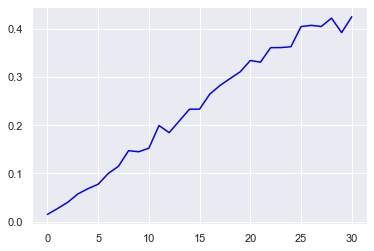

In [7]:
plt.plot(i_beta_31_02, color='blue')

In [8]:
scio.savemat('./i_beta_31_02.mat', {'i_beta_31_02': i_beta_31_02})